In [2]:
import matplotlib.pyplot as plt

In [3]:
from glob import glob
import numpy as np 
from sklearn.decomposition import PCA
import cv2

import torch
import torch.nn as nn
from torch.utils import data

import torch.multiprocessing as mp
from thomas_detector import ThomasDetector, get_piece_mask, calc_rotation
from puzzle_grid import PuzzleGrid, get_xy_min

from vision import *
import imgaug as ia
import imgaug.augmenters as iaa


Using cache found in C:\Users\Thomas/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [4]:
def calc_contour(filtered):
    filtered = (filtered.mean(axis = 2) > 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(filtered, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    biggest_contour = max(contours, key = cv2.contourArea)
    return biggest_contour

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result



In [5]:
def calc_rotation(biggest_contour, step = 2, n_thetas = 100):
    biggest_contour = biggest_contour.reshape(-1, 2)
    derivatives = np.zeros_like(biggest_contour, dtype = np.float32)
    
    for i in range(len(biggest_contour)):
        prev_point = biggest_contour[(i - step) % len(biggest_contour)]
        next_point = biggest_contour[(i + step) % len(biggest_contour) ]
        v = next_point - prev_point
        derivatives[i] = (-v[1], v[0])
        derivatives[i] = derivatives[i] / (0.00001 + np.linalg.norm(derivatives[i]))

    thetas = np.linspace(0, np.pi, n_thetas)
    theta_sums = []
    for theta in thetas:
        rotation_vectors = np.array([[np.sin(theta), np.cos(theta)], 
                                     [np.cos(theta), -np.sin(theta)]])
        errors = np.square((derivatives @ rotation_vectors))
        
        min_vec = (np.min(errors, axis = 1))
#         min_vec = min_vec[min_vec > np.quantile(min_vec, 0.2)]
#         min_vec = min_vec[min_vec < np.quantile(min_vec, 0.7)]
        # min_vec = np.clip(min_vec, np.quantile(min_vec, 0.01), np.quantile(min_vec, 0.99))
        theta_sums.append(np.mean(min_vec))
    
    return thetas[np.argmin(theta_sums)]

def rotate_image_to_flat(img):
    c1 = calc_contour(img)
    r = calc_rotation(c1) % (np.pi/2)
    if (r > np.pi/4):
        r =  np.pi/2-r
    return rotate_image(img, np.rad2deg(r))

In [6]:
from sklearn.neighbors import NearestNeighbors


def contour_similarity(c1, c2, approx_points = 100):
    c1, c2 = c1.reshape(-1, 2), c2.reshape(-1, 2)
    c1 = c1[::int(len(c1) / approx_points)]
    c2 = c2[::int(len(c2) / approx_points)]
    c1 = (c1 - c1.min(axis = 0)) / (c1.max(axis = 0) - c1.min(axis = 0))
    c2 = (c2 - c1.min(axis = 0)) / (c2.max(axis = 0) - c2.min(axis = 0))
    knn = NearestNeighbors(n_neighbors = 1, algorithm = 'brute')
    knn.fit(c1)
    dists, _ = knn.kneighbors(c2)
    return [dists.mean(), dists.std()]

def full_contour_similarity(img1, img2):
    c1 = calc_contour(img1)
    c2 = calc_contour(img2)
    return contour_similarity(c1, c2)

In [7]:

def get_img_lists():
    img_groups = [glob(f'../vision/train_imgs/g{i} *') for i in range(1, 5)]
    img_lists = []
    for img_group in img_groups:

        detector = ThomasDetector()

        img = cv2.cvtColor(cv2.imread(img_group[0])[:, 160:], cv2.COLOR_BGR2RGB) 
        detector.process(img.copy())
        pieces_list = [p for p in detector.pieces if p.is_valid()]

        img_list = [[] for i in range(len(pieces_list))]

        for img_path in img_group:
            img = cv2.cvtColor(cv2.imread(img_path)[:, 160:], cv2.COLOR_BGR2RGB) 
            detector.process(img.copy())

            for i, piece in enumerate(pieces_list):
                img_list[i].append(piece.natural_img * (piece.img.reshape(piece.img.shape[0], piece.img.shape[1], 1) > 128))
            
#             for i, piece in enumerate(pieces_list):
#                 img_list[i].append(piece.natural_img)

        img_lists.append(img_list)

        
    return img_lists

img_lists = get_img_lists()
imgs = []
for img_list1 in img_lists:
    for img_list in img_list1:
        for img in img_list:
            if (len(imgs) == 0 or (img is not imgs[-1])):
                imgs.append(rotate_image_to_flat(img))

In [8]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),
#     iaa.Sometimes(
#         0.5,
#         iaa.GaussianBlur(sigma=(0, 0.5))
#     ),
#     iaa.LinearContrast((0.75, 1.5)),
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.7, 1.3), per_channel=0.33),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-10, 10),
        shear=(-4, 4)
    )
], random_order=True) # apply augmenters in random order

images_augs = [seq(images=imgs[:]) for i in range(4)]

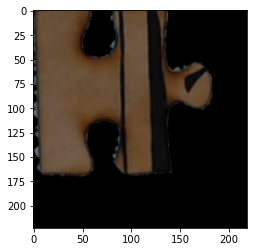

In [9]:
plt.imshow(images_augs[1][0])

In [10]:
def calc_iou(img1, img2, image_size = 124, N = 1):
    img1 = cv2.resize(img1, (image_size, image_size))
    mask1 = cv2.dilate((img1.mean(axis = 2) > 0).astype(np.uint8), None, iterations=N)
    img2 = cv2.resize(img2, (image_size, image_size))
    mask2 = cv2.dilate((img2.mean(axis = 2) > 0).astype(np.uint8), None, iterations=N)
    
#     plt.imshow(img1)
#     plt.show()
    
#     plt.imshow(mask1)
#     plt.show()
    
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(mask2)
#     plt.show()
    
    return (mask1 * mask2).sum() / (mask1.sum() + mask2.sum())

def calc_arc_smape(img1, img2, image_size = 124):
    img1 = cv2.resize(img1, (image_size, image_size))
    img2 = cv2.resize(img2, (image_size, image_size))
    c1, c2 = calc_contour(img1), calc_contour(img2)
    l1, l2 = cv.arcLength(c1, True), cv.arcLength(c2, True) 
    
    return abs(l1 - l2) / (l1 + l2)

In [11]:
from tqdm import tqdm


xs = []
ys = []
n_iters = 3

for i in tqdm(range(len(images_augs[0][:]))):
    for j in range(len(images_augs)):
        for iters in range(n_iters):
            k = np.random.choice([0, 1, 2, 3])
            k_init = np.random.choice([0, 1, 2, 3])
            base_img = (np.rot90(images_augs[j][i], k = k_init))
            rot_img = (np.rot90(images_augs[np.random.randint(0, len(images_augs))][i], k = k))

            ys.append(k == k_init)
            model_diff = run_model(base_img)[0] - run_model(rot_img)[0]
            xs.append(list(np.abs(model_diff)) + [calc_iou(base_img, rot_img)])

100%|████████████████████████████████████████████████████████████████████████████████| 405/405 [15:29<00:00,  2.29s/it]


In [12]:
len(ys)

4860

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [14]:
model = LogisticRegression().fit(xs, ys)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# model.coef_ = model.coef_ * (np.abs(model.coef_) > 0.1)
((model.predict_proba(xs)[:, 1] > 0.45) == ys).mean()

0.8203703703703704

In [16]:
model.intercept_

array([0.58584349])

In [17]:
model.coef_

array([[-4.49081824e-01,  1.12687836e-02,  4.85113796e-01,
         1.70662619e-01,  1.89955882e-02, -5.89564080e-01,
        -7.15204257e-01,  1.27510820e-01, -3.03986061e-01,
        -3.51322496e-01, -3.99617813e-01,  8.63904780e-01,
        -1.83382493e-01, -1.53791225e-01, -4.63326567e-01,
         9.18626120e-02, -4.11118605e-02, -3.12185556e-01,
         2.44983164e-01, -7.22996437e-01, -3.58611556e-02,
        -8.89574219e-02,  2.80122380e-01, -2.15861056e-01,
        -8.51508935e-01,  1.54787657e-01, -1.19536721e-01,
        -3.13194711e-02,  4.47863166e-01,  2.01475597e-01,
        -2.09516714e-03, -1.30780801e-01,  1.16117007e-01,
         4.29281071e-01,  3.01904183e-01, -4.13799253e-01,
         7.44954513e-02,  1.84409829e-01, -2.95420256e-01,
         3.59187507e-01, -1.22753103e+00,  3.38674211e-01,
         2.30627728e-01, -1.26686006e-01, -6.00702247e-01,
        -3.01241257e-01,  3.63822135e-02,  3.50812084e-02,
        -2.51459516e-01, -9.27914942e-01, -3.24184313e-0

In [76]:


#
#   Definitions
#
# Set the approximate piece side length (in pixels).  This is used to
# sub-divide the long side of connected pieces.
SIDELEN = 125

# Set the number of points per side to match against another side.
SIDEPOINTS = 20

# Color List (to show the sides)
COLORLIST = ((000, 000, 255),           # Red
             (000, 255, 000),           # Green
             (255, 000, 000),           # Blue
             (255, 255, 000),           # Yellow
             (000, 255, 255),           # Cyan
             (255, 000, 255),           # Magenta
             (255, 128, 000),           # Orange
             (000, 255, 128),
             (128, 000, 255),
             (255, 000, 128),
             (128, 255, 000),
             (000, 128, 255))

def drawContour(image, contour, color):
    cv2.drawContours(image, [contour], 0, color)

def fillContour(image, contour, color):
    cv2.drawContours(image, [contour], 0, color, thickness=cv2.FILLED)

def drawSide(image, side, color):
    for x,y in side.reshape(-1,2):
        image[y,x] = color

def drawSides(image, sides):
    for i in range(len(sides)):
        drawSide(image, sides[i], COLORLIST[i % len(COLORLIST)])


#
#   Contour Information
#
def centerContour(contour):
    # Compute the center of the contour
    M = cv2.moments(contour)
    x = M["m10"] / M["m00"]
    y = M["m01"] / M["m00"]
    return(np.array([x, y]))

def infoContour(contour):
    # Compute the center of the contour
    c = centerContour(contour)
    print("Contour Center ", c)

    # Compute the contour area.
    A = cv2.contourArea(contour, oriented=False)
    print("Contour Area   ", A)

    # Compute the contour length.
    L = cv2.arcLength(contour, closed=True)
    print("Contour Len    ", L)


#
#   Base Polygon
#
#   Find the polygon underlying a puzzle piece or connected pieces.
#   This basically ignores the holes and tabs and turns each piece
#   into a square.
#
def findBase(contour, imagewidth, imageheight):
    # Create a blank image, to allow the erosion and dilation without
    # interferring with other image elements.
    binary = np.zeros((imageheight, imagewidth), dtype=np.uint8)

    # Draw the original contour shape on the blank image.
    cv2.drawContours(binary, [contour], 0, color=255, thickness=cv2.FILLED)

    # Dilate and erode to remove the holes.
    N = int(SIDELEN/8)
    binary = cv2.dilate(binary, None, iterations=N)
    binary = cv2.erode(binary,  None, iterations=N)

    # Erode and dilate to remove the tabs.
    N = int(SIDELEN/6)
    binary = cv2.erode(binary,  None, iterations=N)
    binary = cv2.dilate(binary, None, iterations=N)
    
    # Re-find the countour of the base shape.  Again, do not
    # approximate, so we get the full list of pixels on the boundary.
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)
    base = contours[0]

    # Convert the base shape into a simple polygon.
    polygon = cv2.approxPolyDP(base, SIDELEN/5, closed=True)
    return(polygon)

def refineCornerIndex(contour, index):
    # Set up the parameters.
    N = len(contour)
    D = int(SIDELEN/6)          # Search a range +/- from the given
    d = int(SIDELEN/8)          # Compute the angle +/- this many pixels
    
    # Search for the best corner fit, checking +/- the given index.
    maxvalue = 0
    for i in range(index-D,index+D+1):
        p  = contour[(i  )%N, 0, :]
        da = contour[(i-d)%N, 0, :] - p
        db = contour[(i+d)%N, 0, :] - p
        value = (da[0]*db[1] - da[1]*db[0])**2
        if value > maxvalue:
            maxvalue = value
            index    = i%N

    # Return the best index.
    return(index)

def findCornerIndices(contour, polygon):
    # Prepare the list of corner indices.
    indices = []

    # Loop of the polygon points, sub-dividing long lines (across
    # multiple pieces) into single pieces.
    N = len(polygon)
    for i in range(N):
        p1 = polygon[ i,      0, :]
        p2 = polygon[(i+1)%N, 0, :]

        # Sub-divide as appropriate.
        n  = int(round(np.linalg.norm(p2-p1) / SIDELEN))
        for j in range(n):
            p = p1*(n-j)/n + p2*j/n

            # Find the lowest distance to all contour points.
            d = np.linalg.norm(contour-p, axis=2)
            index = int(np.argmin(d, axis=0))

            # Refine the corner index for real corners.
            if (j == 0):
                index = refineCornerIndex(contour, index)

            # Use that index.
            indices.append(index)

    # Return the indices.
    return(indices)


#
#   Find Sides
#
#   Process a contour (list of pixels on the boundary) into the sides.
#
def findSides(image, contour):
    # Create the base polygon.
    polygon = findBase(contour, image.shape[1], image.shape[0])

    # Get the indices to the corners.
    indices = findCornerIndices(contour, polygon)

    # Pull out the sides between the indicies.
    sides = []
    N = len(indices)
    for i in range(N):
        index1 = indices[i]
        index2 = indices[(i+1)%N]
        if (index1 <= index2):
            side = contour[index1:index2, 0, :]
        else:
            side = np.vstack((contour[index1:, 0, :],
                              contour[0:index2, 0, :]))
        sides.append(side)


    # Check the number of pieces (just for fun).
    A = cv2.contourArea(polygon, oriented=False)
    n = np.round(A/SIDELEN/SIDELEN)
    print("Guessing contour has %d pieces" % n)

    # Report the indices (just for debugging).
    print("Corner indices ", indices)

    # Show the polygon (just FYI).
    imagecopy = image.copy()
    fillContour(imagecopy, polygon, (200, 200, 200))
    for index in indices:
        cv2.circle(imagecopy, tuple(contour[index,0,:]), 3, (0, 0, 255), -1)
    cv2.imshow("Base polygon and corners", imagecopy)
    cv2.waitKey(0)

    # Return the sides
    return sides



#
#   Select the two contours to demo...
#
def selectContours(image):
    # Isolate the pieces: Convert to HSV and threshold.  The pieces
    # should show color (saturation >5%) or be dark (value <20%).
    # That is, the background (white) is both below 5% saturation and
    # above 20% value.  A simple threshold would probably also work.
    hsv    = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #binary = cv2.bitwise_not(cv2.inRange(hsv, (0, 0, 50), (255, 12, 255)))
    binary = cv2.bitwise_not(cv2.inRange(hsv, (0, 0, 50), (255, 15, 255)))

    # Grab all external contours - skip the internal (inner) holes.
    # Also do not approximate the contour, but report all pixels.
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)

    # Down-select only contours big enough to hold pieces.
    contours = [contour for contour in contours if len(contour) > 2*SIDELEN]

    # Pick the two pieces to process.  Return the larger first.
    if len(contours[0]) > len(contours[1]):
        return (contours[0], contours[1])
    else:
        return (contours[1], contours[0])


#
#   Check the Translation/Orientation/Match between 2 Sides
#
def compareSides(sideA, sideB, center):
    # Grab the points from the two sides, relative to the center.
    M  = SIDEPOINTS
    iA = [int(round(j*(len(sideA)-1)/(M-1))) for j in range(M)]
    iB = [int(round(j*(len(sideB)-1)/(M-1))) for j in range(M-1,-1,-1)]
    pA = sideA[iA] - center
    pB = sideB[iB] - center

    # Pull out a list of the x/y coordinqtes.
    xA = pA[:,0].reshape((-1, 1))
    yA = pA[:,1].reshape((-1, 1))
    xB = pB[:,0].reshape((-1, 1))
    yB = pB[:,1].reshape((-1, 1))
    c0 = np.zeros((M,1))
    c1 = np.ones((M,1))

    # Build up the least squares problem for 4 parameters: dx, dy, cos, sin
    b  = np.hstack(( xA, yA)).reshape((-1,1))
    A1 = np.hstack(( c1, c0)).reshape((-1,1))
    A2 = np.hstack(( c0, c1)).reshape((-1,1))
    A3 = np.hstack((-yB, xB)).reshape((-1,1))
    A4 = np.hstack(( xB, yB)).reshape((-1,1))
    A  = np.hstack((A1, A2, A3, A4))

    param = np.linalg.pinv(A.transpose() @ A) @ (A.transpose() @ b)
    dtheta = np.arctan2(param[2][0], param[3][0])

    # Rebuild the least squares problem for 2 parameters: dx, dy
    b = b - A @ np.array([0, 0, np.sin(dtheta), np.cos(dtheta)]).reshape(-1,1)
    A = A[:, 0:2]

    param = np.linalg.pinv(A.transpose() @ A) @ (A.transpose() @ b)
    dx = param[0][0]
    dy = param[1][0]

    # Check the residual error.
    err = np.linalg.norm(b - A @ param) / np.sqrt(M)

    # Return the data.
    return (dx, dy, dtheta, err)
  